In [3]:
import pandas as pd
import matplotlib.pyplot as plt 

In [6]:
df = pd.read_csv("D:/Coding/Weather App/Weather_ML/data/temperature.csv")
df[:5]

,Temperature,Minimum Temperature,Maximum Temperature,Relative Humidity,Dew Point,Wind Speed,temp_lag1,temp_lag2,temp_mean_3,temp_mean_7,humidity_mean_7,sin_day,cos_day,sin_month,cos_month,target_temp
0,17.8,11.0,25.3,70.19,11.5,8.1,18.5,19.6,18.633333,19.628571,73.621429,0.120208,0.992749,0.5,0.866025,19.1
1,19.1,12.0,26.2,67.10,12.0,8.1,17.8,18.5,18.466667,19.514286,71.425714,0.137279,0.990532,0.5,0.866025,20.0
2,20.0,13.0,27.0,67.08,12.9,5.8,19.1,17.8,18.966667,19.428571,70.042857,0.154309,0.988023,0.5,0.866025,19.0
3,19.0,15.0,23.2,69.32,12.9,16.1,20.0,19.1,19.366667,19.128571,69.500000,0.171293,0.985220,0.5,0.866025,19.3
4,19.3,15.0,24.5,68.48,13.0,9.2,19.0,20.0,19.433333,19.042857,68.915714,0.188227,0.982126,0.5,0.866025,18.2


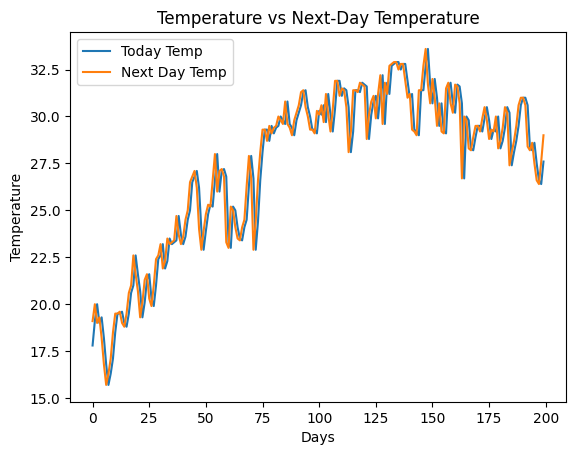

In [7]:
plt.figure()
plt.plot(df["Temperature"][:200], label="Today Temp")
plt.plot(df["target_temp"][:200], label="Next Day Temp")
plt.legend()
plt.title("Temperature vs Next-Day Temperature")
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.show()


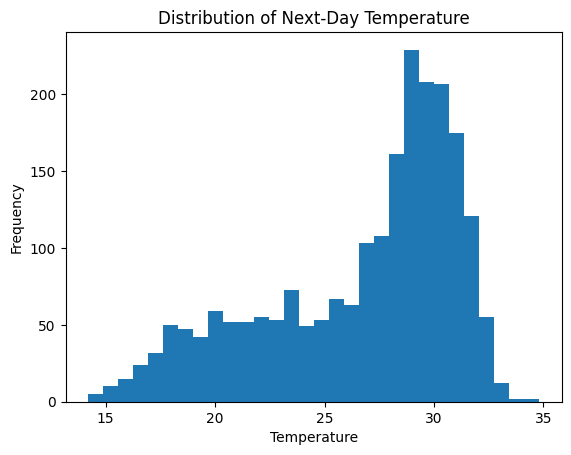

In [8]:
plt.figure()
plt.hist(df["target_temp"], bins=30)
plt.title("Distribution of Next-Day Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()


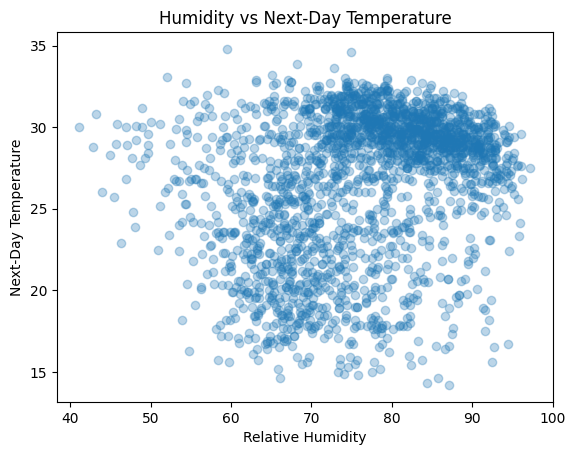

In [9]:
plt.figure()
plt.scatter(df["Relative Humidity"], df["target_temp"], alpha=0.3)
plt.xlabel("Relative Humidity")
plt.ylabel("Next-Day Temperature")
plt.title("Humidity vs Next-Day Temperature")
plt.show()


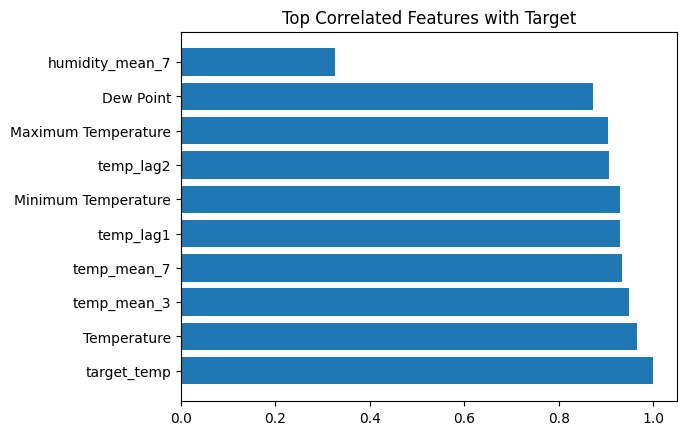

In [10]:
corr = df.corr()["target_temp"].sort_values(ascending=False)

plt.figure()
plt.barh(corr.index[:10], corr.values[:10])
plt.title("Top Correlated Features with Target")
plt.show()
